# Notebook AIFairLearn360

## Imports

In [104]:
import os
import datetime
import logging

from modules.gen_purp.get_repo import get_uci_repo
from modules.gen_purp.data_preprocessing import preprocessing
from modules.display.data_display import DataDisplay

# Note: Everything from the sklearn library apparently requires r-liraries, which are not working properly
# from aif360.sklearn.preprocessing import LearnedFairRepresentations
# from aif360.sklearn.inprocessing import AdversarialDebiasing
# from modules.aif360.aif360_instance import Aif360Instance
from aif360.sklearn.postprocessing import RejectOptionClassifierCV, PostProcessingMeta
from aif360.sklearn.metrics import consistency_score
from aif360.datasets import BinaryLabelDataset
from aif360.sklearn.detectors import bias_scan

import sklearn
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier

import pandas as pd
import matplotlib.pyplot as plt

from IPython.display import Markdown, display, HTML

## Config

In [105]:
now = datetime.datetime.now()

cfg = {
    'main_path': os.getcwd(),
    'now': now,
    'log': {
        'log_level': logging.WARNING,
        'log_fmt': '%(name)s - %(levelname)s - %(message)s'
        },
    'read': {
        'sep': ','
    },
    'display': {
        'out_file': os.path.join(os.getcwd(), 'out', f'display_{now.day}-{now.month}-{now.year}.txt'),
        'inst': ('head', 'summary', 'describe', 'skew', 'standard_error')
    }
}

## Student Performance Data 


By: Cortez, A. M. G. Silva. 2008. 
https://archive.ics.uci.edu/dataset/320/student+performance

In [106]:
# Get the data
data = get_uci_repo(main_path=cfg['main_path'], data_name='student_performance', data_id=320)

### Initial look at the data

In [107]:
feat, targ = data[0], data[1]

In [108]:
# Display the features
display(HTML(feat.head(10).to_html()))

,Unnamed: 0,school,sex,age,address,famsize,Pstatus,Medu,Fedu,Mjob,Fjob,reason,guardian,traveltime,studytime,failures,schoolsup,famsup,paid,activities,nursery,higher,internet,romantic,famrel,freetime,goout,Dalc,Walc,health,absences
0,0,GP,F,18,U,GT3,A,4,4,at_home,teacher,course,mother,2,2,0,yes,no,no,no,yes,yes,no,no,4,3,4,1,1,3,4
1,1,GP,F,17,U,GT3,T,1,1,at_home,other,course,father,1,2,0,no,yes,no,no,no,yes,yes,no,5,3,3,1,1,3,2
2,2,GP,F,15,U,LE3,T,1,1,at_home,other,other,mother,1,2,0,yes,no,no,no,yes,yes,yes,no,4,3,2,2,3,3,6
3,3,GP,F,15,U,GT3,T,4,2,health,services,home,mother,1,3,0,no,yes,no,yes,yes,yes,yes,yes,3,2,2,1,1,5,0
4,4,GP,F,16,U,GT3,T,3,3,other,other,home,father,1,2,0,no,yes,no,no,yes,yes,no,no,4,3,2,1,2,5,0
5,5,GP,M,16,U,LE3,T,4,3,services,other,reputation,mother,1,2,0,no,yes,no,yes,yes,yes,yes,no,5,4,2,1,2,5,6
6,6,GP,M,16,U,LE3,T,2,2,other,other,home,mother,1,2,0,no,no,no,no,yes,yes,yes,no,4,4,4,1,1,3,0
7,7,GP,F,17,U,GT3,A,4,4,other,teacher,home,mother,2,2,0,yes,yes,no,no,yes,yes,no,no,4,1,4,1,1,1,2
8,8,GP,M,15,U,LE3,A,3,2,services,other,home,mother,1,2,0,no,yes,no,no,yes,yes,yes,no,4,2,2,1,1,1,0
9,9,GP,M,15,U,GT3,T,3,4,other,other,home,mother,1,2,0,no,yes,no,yes,yes,yes,yes,no,5,5,1,1,1,5,0


In [109]:
display(HTML(feat.tail(10).to_html()))

,Unnamed: 0,school,sex,age,address,famsize,Pstatus,Medu,Fedu,Mjob,Fjob,reason,guardian,traveltime,studytime,failures,schoolsup,famsup,paid,activities,nursery,higher,internet,romantic,famrel,freetime,goout,Dalc,Walc,health,absences
639,639,MS,M,19,R,GT3,T,1,1,other,services,other,mother,2,1,1,no,no,no,no,yes,yes,no,no,4,3,2,1,3,5,0
640,640,MS,M,18,R,GT3,T,4,2,other,other,home,father,2,1,1,no,no,yes,no,yes,yes,no,no,5,4,3,4,3,3,0
641,641,MS,F,18,R,GT3,T,2,2,at_home,other,other,mother,2,3,0,no,no,no,no,yes,yes,no,no,5,3,3,1,3,4,0
642,642,MS,F,17,U,GT3,T,4,3,teacher,other,other,mother,2,2,0,no,no,no,no,yes,yes,yes,no,5,5,4,1,1,1,0
643,643,MS,F,18,R,GT3,T,4,4,teacher,at_home,reputation,mother,3,1,0,no,yes,no,yes,yes,yes,yes,yes,4,4,3,2,2,5,4
644,644,MS,F,19,R,GT3,T,2,3,services,other,course,mother,1,3,1,no,no,no,yes,no,yes,yes,no,5,4,2,1,2,5,4
645,645,MS,F,18,U,LE3,T,3,1,teacher,services,course,mother,1,2,0,no,yes,no,no,yes,yes,yes,no,4,3,4,1,1,1,4
646,646,MS,F,18,U,GT3,T,1,1,other,other,course,mother,2,2,0,no,no,no,yes,yes,yes,no,no,1,1,1,1,1,5,6
647,647,MS,M,17,U,LE3,T,3,1,services,services,course,mother,2,1,0,no,no,no,no,no,yes,yes,no,2,4,5,3,4,2,6
648,648,MS,M,18,R,LE3,T,3,2,services,other,course,mother,3,1,0,no,no,no,no,no,yes,yes,no,4,4,1,3,4,5,4


In [110]:
# Display the targets
display(HTML(targ.head(15).to_html()))

,Unnamed: 0,G1,G2,G3
0,0,0,11,11
1,1,9,11,11
2,2,12,13,12
3,3,14,14,14
4,4,11,13,13
5,5,12,12,13
6,6,13,12,13
7,7,10,13,13
8,8,15,16,17
9,9,12,12,13


In [111]:
# Get the skew
feat.skew(numeric_only=True)

Unnamed: 0    0.000000
age           0.416795
Medu         -0.029950
Fedu          0.215343
traveltime    1.247648
studytime     0.699619
failures      3.092699
famrel       -1.105934
freetime     -0.181277
goout        -0.008580
Dalc          2.141913
Walc          0.635904
health       -0.500656
absences      2.020694
dtype: float64

## Initial Data Exploration - Student Performance:

- Initial suspicion of data bias in ML models: gender, age, address (rural or urban), Medu (mother's education), Fedu (father's education), failures, activities, famrel (family relationship),
Dalc (alcohol consumption on working day), absences
- Processing of many categorical values
- Some strong bias in absenteeism and workday drinking -> Might be interesting to test more intensively
- Most interesting will probably be the final grade (G3) for now

## Data Preprocessing

In [112]:
# Drop NAs and get the dummies of the features
pre_feat, pre_targ = preprocessing((feat, targ))
pre_targ = pre_targ['G3']

### Check the features again

In [113]:
display(HTML(pre_feat.head(10).to_html()))

,Unnamed: 0,age,Medu,Fedu,traveltime,studytime,failures,famrel,freetime,goout,Dalc,Walc,health,absences,school_GP,school_MS,sex_F,sex_M,address_R,address_U,famsize_GT3,famsize_LE3,Pstatus_A,Pstatus_T,Mjob_at_home,Mjob_health,Mjob_other,Mjob_services,Mjob_teacher,Fjob_at_home,Fjob_health,Fjob_other,Fjob_services,Fjob_teacher,reason_course,reason_home,reason_other,reason_reputation,guardian_father,guardian_mother,guardian_other,schoolsup_no,schoolsup_yes,famsup_no,famsup_yes,paid_no,paid_yes,activities_no,activities_yes,nursery_no,nursery_yes,higher_no,higher_yes,internet_no,internet_yes,romantic_no,romantic_yes
0,0,18,4,4,2,2,0,4,3,4,1,1,3,4,True,False,True,False,False,True,True,False,True,False,True,False,False,False,False,False,False,False,False,True,True,False,False,False,False,True,False,False,True,True,False,True,False,True,False,False,True,False,True,True,False,True,False
1,1,17,1,1,1,2,0,5,3,3,1,1,3,2,True,False,True,False,False,True,True,False,False,True,True,False,False,False,False,False,False,True,False,False,True,False,False,False,True,False,False,True,False,False,True,True,False,True,False,True,False,False,True,False,True,True,False
2,2,15,1,1,1,2,0,4,3,2,2,3,3,6,True,False,True,False,False,True,False,True,False,True,True,False,False,False,False,False,False,True,False,False,False,False,True,False,False,True,False,False,True,True,False,True,False,True,False,False,True,False,True,False,True,True,False
3,3,15,4,2,1,3,0,3,2,2,1,1,5,0,True,False,True,False,False,True,True,False,False,True,False,True,False,False,False,False,False,False,True,False,False,True,False,False,False,True,False,True,False,False,True,True,False,False,True,False,True,False,True,False,True,False,True
4,4,16,3,3,1,2,0,4,3,2,1,2,5,0,True,False,True,False,False,True,True,False,False,True,False,False,True,False,False,False,False,True,False,False,False,True,False,False,True,False,False,True,False,False,True,True,False,True,False,False,True,False,True,True,False,True,False
5,5,16,4,3,1,2,0,5,4,2,1,2,5,6,True,False,False,True,False,True,False,True,False,True,False,False,False,True,False,False,False,True,False,False,False,False,False,True,False,True,False,True,False,False,True,True,False,False,True,False,True,False,True,False,True,True,False
6,6,16,2,2,1,2,0,4,4,4,1,1,3,0,True,False,False,True,False,True,False,True,False,True,False,False,True,False,False,False,False,True,False,False,False,True,False,False,False,True,False,True,False,True,False,True,False,True,False,False,True,False,True,False,True,True,False
7,7,17,4,4,2,2,0,4,1,4,1,1,1,2,True,False,True,False,False,True,True,False,True,False,False,False,True,False,False,False,False,False,False,True,False,True,False,False,False,True,False,False,True,False,True,True,False,True,False,False,True,False,True,True,False,True,False
8,8,15,3,2,1,2,0,4,2,2,1,1,1,0,True,False,False,True,False,True,False,True,True,False,False,False,False,True,False,False,False,True,False,False,False,True,False,False,False,True,False,True,False,False,True,True,False,True,False,False,True,False,True,False,True,True,False
9,9,15,3,4,1,2,0,5,5,1,1,1,5,0,True,False,False,True,False,True,True,False,False,True,False,False,True,False,False,False,False,True,False,False,False,True,False,False,False,True,False,True,False,False,True,True,False,False,True,False,True,False,True,False,True,True,False


In [114]:
display(HTML(pre_feat.tail(10).to_html()))

,Unnamed: 0,age,Medu,Fedu,traveltime,studytime,failures,famrel,freetime,goout,Dalc,Walc,health,absences,school_GP,school_MS,sex_F,sex_M,address_R,address_U,famsize_GT3,famsize_LE3,Pstatus_A,Pstatus_T,Mjob_at_home,Mjob_health,Mjob_other,Mjob_services,Mjob_teacher,Fjob_at_home,Fjob_health,Fjob_other,Fjob_services,Fjob_teacher,reason_course,reason_home,reason_other,reason_reputation,guardian_father,guardian_mother,guardian_other,schoolsup_no,schoolsup_yes,famsup_no,famsup_yes,paid_no,paid_yes,activities_no,activities_yes,nursery_no,nursery_yes,higher_no,higher_yes,internet_no,internet_yes,romantic_no,romantic_yes
639,639,19,1,1,2,1,1,4,3,2,1,3,5,0,False,True,False,True,True,False,True,False,False,True,False,False,True,False,False,False,False,False,True,False,False,False,True,False,False,True,False,True,False,True,False,True,False,True,False,False,True,False,True,True,False,True,False
640,640,18,4,2,2,1,1,5,4,3,4,3,3,0,False,True,False,True,True,False,True,False,False,True,False,False,True,False,False,False,False,True,False,False,False,True,False,False,True,False,False,True,False,True,False,False,True,True,False,False,True,False,True,True,False,True,False
641,641,18,2,2,2,3,0,5,3,3,1,3,4,0,False,True,True,False,True,False,True,False,False,True,True,False,False,False,False,False,False,True,False,False,False,False,True,False,False,True,False,True,False,True,False,True,False,True,False,False,True,False,True,True,False,True,False
642,642,17,4,3,2,2,0,5,5,4,1,1,1,0,False,True,True,False,False,True,True,False,False,True,False,False,False,False,True,False,False,True,False,False,False,False,True,False,False,True,False,True,False,True,False,True,False,True,False,False,True,False,True,False,True,True,False
643,643,18,4,4,3,1,0,4,4,3,2,2,5,4,False,True,True,False,True,False,True,False,False,True,False,False,False,False,True,True,False,False,False,False,False,False,False,True,False,True,False,True,False,False,True,True,False,False,True,False,True,False,True,False,True,False,True
644,644,19,2,3,1,3,1,5,4,2,1,2,5,4,False,True,True,False,True,False,True,False,False,True,False,False,False,True,False,False,False,True,False,False,True,False,False,False,False,True,False,True,False,True,False,True,False,False,True,True,False,False,True,False,True,True,False
645,645,18,3,1,1,2,0,4,3,4,1,1,1,4,False,True,True,False,False,True,False,True,False,True,False,False,False,False,True,False,False,False,True,False,True,False,False,False,False,True,False,True,False,False,True,True,False,True,False,False,True,False,True,False,True,True,False
646,646,18,1,1,2,2,0,1,1,1,1,1,5,6,False,True,True,False,False,True,True,False,False,True,False,False,True,False,False,False,False,True,False,False,True,False,False,False,False,True,False,True,False,True,False,True,False,False,True,False,True,False,True,True,False,True,False
647,647,17,3,1,2,1,0,2,4,5,3,4,2,6,False,True,False,True,False,True,False,True,False,True,False,False,False,True,False,False,False,False,True,False,True,False,False,False,False,True,False,True,False,True,False,True,False,True,False,True,False,False,True,False,True,True,False
648,648,18,3,2,3,1,0,4,4,1,3,4,5,4,False,True,False,True,True,False,False,True,False,True,False,False,False,True,False,False,False,True,False,False,True,False,False,False,False,True,False,True,False,True,False,True,False,True,False,True,False,False,True,False,True,True,False


In [115]:
pre_targ.unique()

array([11, 12, 14, 13, 17, 15,  7, 10, 16,  9,  8, 18,  6,  0,  1,  5, 19],
      dtype=int64)

## Initial check of model performance

In [116]:
# Split train & test data
feat_train, feat_test, targ_train, targ_test =  sklearn.model_selection.train_test_split(pre_feat, pre_targ, test_size=0.2)

In [117]:
# Train the model
rf = RandomForestClassifier().fit(feat_train, targ_train)

In [118]:
# Check the results
rf_pred = rf.predict(feat_test)
rf_pred

array([10, 15, 12, 11, 11,  8, 11, 17, 15,  9, 12, 13, 10, 12, 12, 11, 10,
       11, 16, 18, 11, 10, 11, 11, 14, 13, 10, 11, 11, 13, 13, 13, 11, 13,
       11, 10, 13, 10, 13, 14, 11, 15, 14, 10, 14, 11, 10, 10,  0, 13, 10,
       13, 12, 14, 13, 11,  9, 10, 11, 11, 11, 12, 13, 14, 10, 11, 13, 10,
       16, 13, 12, 11, 11, 11, 10, 13, 11, 11, 10, 10, 10, 10, 11, 11, 14,
       14, 11, 14, 10, 11, 13, 10, 10, 11, 13, 10, 11, 16, 15, 10, 13, 11,
       13, 10, 11, 15, 13, 15, 11, 11, 12, 10, 11, 12, 11, 13, 11, 14, 11,
       11, 12, 11, 11, 13, 10, 13, 12, 13, 11, 11], dtype=int64)

In [119]:
# Some classification scores
print(f'Precision: {sklearn.metrics.precision_score(targ_test, rf_pred, average="weighted", zero_division=True)}')
print(f'Accuracy: {sklearn.metrics.accuracy_score(targ_test, rf_pred)}')
print(f'F1-Score: {sklearn.metrics.f1_score(targ_test, rf_pred, average="weighted",)}')
print(f'Recall: {sklearn.metrics.recall_score(targ_test, rf_pred, average="weighted",)}')

Precision: 0.22436999692813647
Accuracy: 0.19230769230769232
F1-Score: 0.1733945952319698
Recall: 0.19230769230769232


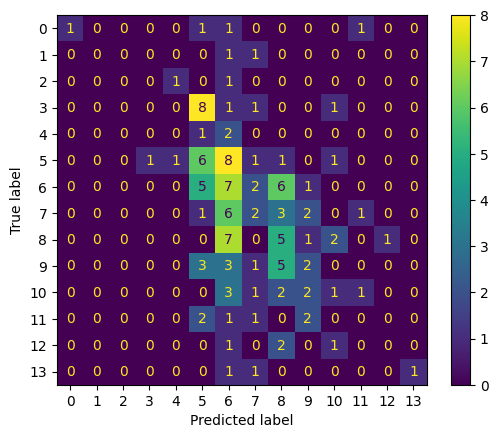

In [120]:
# Confusion matrix
init_cf = sklearn.metrics.confusion_matrix(targ_test, rf_pred)
init_cf_displ = sklearn.metrics.ConfusionMatrixDisplay(init_cf)

init_cf_displ.plot()
plt.show()

## Usage of AIF360

In [121]:
# First, get the columns to "de-bias"
# age, address (rural or urban), Medu (Mother Education), Fedu (Father Education), failures, activities, famrel (family relationship),
# Dalc (Workday alcohol consumption), abscences

# Current col names
print(pre_feat.columns)

Index(['Unnamed: 0', 'age', 'Medu', 'Fedu', 'traveltime', 'studytime',
       'failures', 'famrel', 'freetime', 'goout', 'Dalc', 'Walc', 'health',
       'absences', 'school_GP', 'school_MS', 'sex_F', 'sex_M', 'address_R',
       'address_U', 'famsize_GT3', 'famsize_LE3', 'Pstatus_A', 'Pstatus_T',
       'Mjob_at_home', 'Mjob_health', 'Mjob_other', 'Mjob_services',
       'Mjob_teacher', 'Fjob_at_home', 'Fjob_health', 'Fjob_other',
       'Fjob_services', 'Fjob_teacher', 'reason_course', 'reason_home',
       'reason_other', 'reason_reputation', 'guardian_father',
       'guardian_mother', 'guardian_other', 'schoolsup_no', 'schoolsup_yes',
       'famsup_no', 'famsup_yes', 'paid_no', 'paid_yes', 'activities_no',
       'activities_yes', 'nursery_no', 'nursery_yes', 'higher_no',
       'higher_yes', 'internet_no', 'internet_yes', 'romantic_no',
       'romantic_yes'],
      dtype='object')


### Start of the preprocessing to work with aif360

In [122]:
# Start with the potentially privelidged group
protec_attr_names = ['age']

In [123]:
# Create a Binary Label Dataset
from aif360.datasets import StructuredDataset
from aif360.datasets.multiclass_label_dataset import MulticlassLabelDataset
from aif360.datasets import StandardDataset
# Merge the training data again
train_con = pd.concat([pre_feat, pre_targ], axis=1)

# Can be done with Standard Datasets by providing a function
# pre_feat['sex_F'] = pre_feat['sex_F'].apply(lambda x: 0)
# pre_feat['sex_M'] = pre_feat['sex_M'].apply(lambda x: 1)
# print(pre_feat[['sex_F', 'sex_M']].head())

sd = StandardDataset(df=train_con, 
                    label_name='G3',
                    favorable_classes=[1],
                    privileged_classes=[lambda x: x >= 17],
                    categorical_features=[],
                    protected_attribute_names=protec_attr_names)

In [ ]:
# Another test with non-encoded features

# Drop the other protectable values
non_enc_df = feat.drop(columns='sex')

# Convert "yes" and "no" to boolean values
non_enc_df = non_enc_df.map(lambda x: 1 if isinstance(x, object) and x == 'yes' else 0 if isinstance(x, object) and x == 'no' else x)

sd_alt = StandardDataset(df=non_enc_df, 
                    label_name='age',
                    favorable_classes=[1],
                    privileged_classes=[lambda x: x >= 17],
                    protected_attribute_names=protec_attr_names,
                    categorical_features=['school','address','famsize', 'Pstatus','Mjob', 'Fjob', 'reason', 'guardian']
)


print(non_enc_df.dtypes)
                             

## Rationale of aif360 Datasets

> label_name = target class
> favourable_classes = symbol indicating the class that is considered favourable to the bias
> priviliged_classes = can be used to separate a column into favourable & unfavourable classes (i.e. 1 and 0)
> protected_attribute_names = columns around which the rest of the data is to be balanced (i.e. the data of everything classified as favourable is used for everything classified as unfavourable)

In [125]:
from aif360.metrics import BinaryLabelDatasetMetric

privileged_groups = [{'age': 1}]
unprivileged_groups = [{'age': 0}]



metric_orig_train = BinaryLabelDatasetMetric(sd_alt, 
                                             unprivileged_groups=unprivileged_groups,
                                             privileged_groups=privileged_groups)
display(Markdown("#### Original training dataset"))
print("Difference in mean outcomes between unprivileged and privileged groups = %f" % metric_orig_train.mean_difference())



#### Original training dataset

Difference in mean outcomes between unprivileged and privileged groups = -1.000000


In [126]:
# New train_test split
sd_train, sd_test = sd_alt.split([0.8], shuffle=True)

### Preprocessing algorithms

For the categorical data:

- Reweighing

In [ ]:
from aif360.algorithms.preprocessing import Reweighing

RW = Reweighing(unprivileged_groups=unprivileged_groups,
                privileged_groups=privileged_groups)
sd_rew = RW.fit_transform(sd_alt)


In [128]:
metric_transf_train = BinaryLabelDatasetMetric(sd_rew, 
                                               unprivileged_groups=unprivileged_groups,
                                               privileged_groups=privileged_groups)
display(Markdown("#### Transformed training dataset"))
print("Difference in mean outcomes between unprivileged and privileged groups = %f" % metric_transf_train.mean_difference())

#### Transformed training dataset

Difference in mean outcomes between unprivileged and privileged groups = -1.000000


In [129]:
reweighed_df = sd_rew.convert_to_dataframe()[0]

display(HTML(reweighed_df.head(10).to_html()))

,Unnamed: 0,Medu,Fedu,traveltime,studytime,failures,schoolsup,famsup,paid,activities,nursery,higher,internet,romantic,famrel,freetime,goout,Dalc,Walc,health,absences,school=GP,school=MS,address=R,address=U,famsize=GT3,famsize=LE3,Pstatus=A,Pstatus=T,Mjob=at_home,Mjob=health,Mjob=other,Mjob=services,Mjob=teacher,Fjob=at_home,Fjob=health,Fjob=other,Fjob=services,Fjob=teacher,reason=course,reason=home,reason=other,reason=reputation,guardian=father,guardian=mother,guardian=other,age
0,0.0,4.0,4.0,2.0,2.0,0.0,1.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,4.0,3.0,4.0,1.0,1.0,3.0,4.0,1.0,0.0,0.0,1.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0
1,1.0,1.0,1.0,1.0,2.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,1.0,0.0,5.0,3.0,3.0,1.0,1.0,3.0,2.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0
2,2.0,1.0,1.0,1.0,2.0,0.0,1.0,0.0,0.0,0.0,1.0,1.0,1.0,0.0,4.0,3.0,2.0,2.0,3.0,3.0,6.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0
3,3.0,4.0,2.0,1.0,3.0,0.0,0.0,1.0,0.0,1.0,1.0,1.0,1.0,1.0,3.0,2.0,2.0,1.0,1.0,5.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0
4,4.0,3.0,3.0,1.0,2.0,0.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0,4.0,3.0,2.0,1.0,2.0,5.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0
5,5.0,4.0,3.0,1.0,2.0,0.0,0.0,1.0,0.0,1.0,1.0,1.0,1.0,0.0,5.0,4.0,2.0,1.0,2.0,5.0,6.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0
6,6.0,2.0,2.0,1.0,2.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,0.0,4.0,4.0,4.0,1.0,1.0,3.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0
7,7.0,4.0,4.0,2.0,2.0,0.0,1.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0,4.0,1.0,4.0,1.0,1.0,1.0,2.0,1.0,0.0,0.0,1.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0
8,8.0,3.0,2.0,1.0,2.0,0.0,0.0,1.0,0.0,0.0,1.0,1.0,1.0,0.0,4.0,2.0,2.0,1.0,1.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0
9,9.0,3.0,4.0,1.0,2.0,0.0,0.0,1.0,0.0,1.0,1.0,1.0,1.0,0.0,5.0,5.0,1.0,1.0,1.0,5.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0


In [130]:
display(HTML(reweighed_df.tail(10).to_html()))

,Unnamed: 0,Medu,Fedu,traveltime,studytime,failures,schoolsup,famsup,paid,activities,nursery,higher,internet,romantic,famrel,freetime,goout,Dalc,Walc,health,absences,school=GP,school=MS,address=R,address=U,famsize=GT3,famsize=LE3,Pstatus=A,Pstatus=T,Mjob=at_home,Mjob=health,Mjob=other,Mjob=services,Mjob=teacher,Fjob=at_home,Fjob=health,Fjob=other,Fjob=services,Fjob=teacher,reason=course,reason=home,reason=other,reason=reputation,guardian=father,guardian=mother,guardian=other,age
639,639.0,1.0,1.0,2.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,4.0,3.0,2.0,1.0,3.0,5.0,0.0,0.0,1.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0
640,640.0,4.0,2.0,2.0,1.0,1.0,0.0,0.0,1.0,0.0,1.0,1.0,0.0,0.0,5.0,4.0,3.0,4.0,3.0,3.0,0.0,0.0,1.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0
641,641.0,2.0,2.0,2.0,3.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,5.0,3.0,3.0,1.0,3.0,4.0,0.0,0.0,1.0,1.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0
642,642.0,4.0,3.0,2.0,2.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,0.0,5.0,5.0,4.0,1.0,1.0,1.0,0.0,0.0,1.0,0.0,1.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0
643,643.0,4.0,4.0,3.0,1.0,0.0,0.0,1.0,0.0,1.0,1.0,1.0,1.0,1.0,4.0,4.0,3.0,2.0,2.0,5.0,4.0,0.0,1.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0
644,644.0,2.0,3.0,1.0,3.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,1.0,0.0,5.0,4.0,2.0,1.0,2.0,5.0,4.0,0.0,1.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0
645,645.0,3.0,1.0,1.0,2.0,0.0,0.0,1.0,0.0,0.0,1.0,1.0,1.0,0.0,4.0,3.0,4.0,1.0,1.0,1.0,4.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0
646,646.0,1.0,1.0,2.0,2.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,1.0,1.0,1.0,1.0,1.0,5.0,6.0,0.0,1.0,0.0,1.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0
647,647.0,3.0,1.0,2.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,2.0,4.0,5.0,3.0,4.0,2.0,6.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0
648,648.0,3.0,2.0,3.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,4.0,4.0,1.0,3.0,4.0,5.0,4.0,0.0,1.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0


In [131]:
# Split train & test data
re_feat_train, re_feat_test, re_targ_train, re_targ_test = sklearn.model_selection.train_test_split(reweighed_df, pre_targ, test_size=0.2)
# Train the model
re_rf = RandomForestClassifier().fit(re_feat_train, re_targ_train)

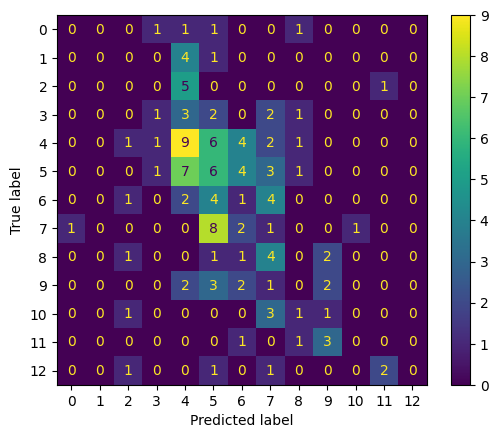

In [132]:
# Confusion matrix
re_pred = re_rf.predict(re_feat_test)

re_cf = sklearn.metrics.confusion_matrix(re_targ_test, re_pred)
re_cf_displ = sklearn.metrics.ConfusionMatrixDisplay(re_cf)

re_cf_displ.plot()
plt.show()

In [133]:
print(f'Precision: {sklearn.metrics.precision_score(re_targ_test, re_pred, average="weighted", zero_division=True)}')
print(f'Accuracy: {sklearn.metrics.accuracy_score(re_targ_test, re_pred)}')
print(f'F1-Score: {sklearn.metrics.f1_score(re_targ_test, re_pred, average="weighted",)}')
print(f'Recall: {sklearn.metrics.recall_score(re_targ_test, re_pred, average="weighted")}')

Precision: 0.2054961704961705
Accuracy: 0.15384615384615385
F1-Score: 0.13568753651154222
Recall: 0.15384615384615385


Result:

Overall, minimal improvements, while Reweighing apparently converts every target to a binary

In [134]:
from aif360.algorithms.preprocessing.lfr import LFR

lfr_ds = LFR(unprivileged_groups=unprivileged_groups, privileged_groups=privileged_groups)
lfr_tf = lfr_ds.fit_transform(dataset=sd_alt)


In [135]:
metric_transf_train = BinaryLabelDatasetMetric(sd_alt, 
                                               unprivileged_groups=unprivileged_groups,
                                               privileged_groups=privileged_groups)
display(Markdown("#### Transformed training dataset"))
print("Difference in mean outcomes between unprivileged and privileged groups = %f" % metric_transf_train.mean_difference())

#### Transformed training dataset

Difference in mean outcomes between unprivileged and privileged groups = -1.000000


In [136]:
lfr_df = lfr_tf.convert_to_dataframe()[0]

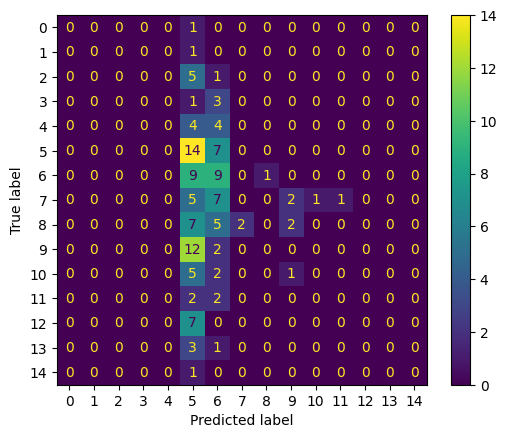

In [137]:
lfr_feat_train, lfr_feat_test, lfr_targ_train, lfr_targ_test = sklearn.model_selection.train_test_split(lfr_df, pre_targ, test_size=0.2)
# Train the model
lfr_rf = RandomForestClassifier().fit(lfr_feat_train, lfr_targ_train)
# Confusion matrix
lfr_pred = lfr_rf.predict(lfr_feat_test)

lfr_cf = sklearn.metrics.confusion_matrix(lfr_targ_test, lfr_pred)
lfr_cf_displ = sklearn.metrics.ConfusionMatrixDisplay(lfr_cf)

lfr_cf_displ.plot()
plt.show()

In [138]:
print(f'Precision: {sklearn.metrics.precision_score(lfr_targ_test, lfr_pred, average="weighted", zero_division=True)}')
print(f'Accuracy: {sklearn.metrics.accuracy_score(lfr_targ_test, lfr_pred)}')
print(f'F1-Score: {sklearn.metrics.f1_score(lfr_targ_test, lfr_pred, average="weighted",)}')
print(f'Recall: {sklearn.metrics.recall_score(lfr_targ_test, lfr_pred, average="weighted")}')

Precision: 0.306114815417141
Accuracy: 0.17692307692307693
F1-Score: 0.08858560794044666
Recall: 0.17692307692307693


In [139]:
import tensorflow.compat.v1 as tf
tf.disable_eager_execution()

In [ ]:
# Inprocessing debiasing  via Adversarial Debiasing
from aif360.algorithms.inprocessing.adversarial_debiasing import AdversarialDebiasing
adv_feat_train, adv_feat_test, adv_targ_train, adv_targ_test = sklearn.model_selection.train_test_split(non_enc_df, pre_targ, test_size=0.2)

adv_sd = StandardDataset(df=adv_feat_train, 
                    label_name='age',
                    favorable_classes=[1],
                    privileged_classes=[lambda x: x >= 17],
                    protected_attribute_names=protec_attr_names,
                    categorical_features=['school','address','famsize', 'Pstatus','Mjob', 'Fjob', 'reason', 'guardian',]
)

adv_sd_test = StandardDataset(df=adv_feat_test, 
                    label_name='age',
                    favorable_classes=[1],
                    privileged_classes=[lambda x: x >= 17],
                    protected_attribute_names=protec_attr_names,
                    categorical_features=['school','address','famsize', 'Pstatus','Mjob', 'Fjob', 'reason', 'guardian',]
)

tf.reset_default_graph()
sess = tf.Session()

# Train Test Split


adv_deb_ds = AdversarialDebiasing(privileged_groups = privileged_groups,
                          unprivileged_groups = unprivileged_groups,
                          scope_name='debiased_classifier',
                          debias=True,
                          sess=sess)
adv_ds = adv_deb_ds.fit_predict(adv_sd)

In [165]:
adv_df = adv_ds.convert_to_dataframe()[0]
display(HTML(adv_df.head(10).to_html()))

,Unnamed: 0,Medu,Fedu,traveltime,studytime,failures,schoolsup,famsup,paid,activities,nursery,higher,internet,romantic,famrel,freetime,goout,Dalc,Walc,health,absences,school=GP,school=MS,address=R,address=U,famsize=GT3,famsize=LE3,Pstatus=A,Pstatus=T,Mjob=at_home,Mjob=health,Mjob=other,Mjob=services,Mjob=teacher,Fjob=at_home,Fjob=health,Fjob=other,Fjob=services,Fjob=teacher,reason=course,reason=home,reason=other,reason=reputation,guardian=father,guardian=mother,guardian=other,age
580,580.0,1.0,1.0,3.0,1.0,1.0,0.0,1.0,0.0,0.0,1.0,1.0,1.0,0.0,4.0,4.0,4.0,3.0,3.0,5.0,4.0,0.0,1.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0
439,439.0,3.0,3.0,2.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,4.0,1.0,3.0,1.0,1.0,4.0,0.0,0.0,1.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
319,319.0,4.0,4.0,2.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,0.0,3.0,2.0,4.0,1.0,4.0,3.0,6.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0
598,598.0,1.0,2.0,2.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,4.0,1.0,4.0,5.0,5.0,1.0,8.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0
535,535.0,1.0,2.0,3.0,2.0,0.0,0.0,1.0,0.0,1.0,1.0,1.0,0.0,0.0,5.0,5.0,5.0,1.0,3.0,5.0,11.0,0.0,1.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
387,387.0,2.0,2.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,5.0,4.0,2.0,1.0,2.0,5.0,6.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0
646,646.0,1.0,1.0,2.0,2.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,1.0,1.0,1.0,1.0,1.0,5.0,6.0,0.0,1.0,0.0,1.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0
372,372.0,2.0,2.0,1.0,2.0,0.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0,1.0,4.0,2.0,2.0,1.0,1.0,3.0,4.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0
293,293.0,1.0,1.0,1.0,3.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,4.0,4.0,3.0,2.0,3.0,3.0,4.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0
177,177.0,1.0,3.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,5.0,3.0,3.0,1.0,4.0,2.0,2.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0


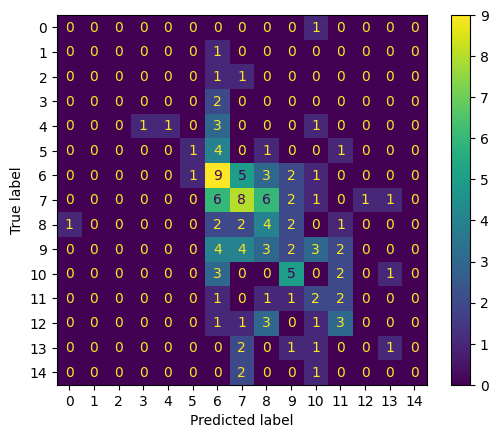

In [175]:
# Train the model
adv_rf = RandomForestClassifier().fit(adv_df, adv_targ_train)
# Confusion matrix
adv_pred = adv_rf.predict(adv_sd_test.convert_to_dataframe()[0])

adv_cf = sklearn.metrics.confusion_matrix(adv_targ_test, adv_pred)
adv_displ = sklearn.metrics.ConfusionMatrixDisplay(adv_cf)

adv_displ.plot()
plt.show()

sess.close()


In [171]:
metric_transf_train = BinaryLabelDatasetMetric(adv_ds, 
                                               unprivileged_groups=unprivileged_groups,
                                               privileged_groups=privileged_groups)
display(Markdown("#### Transformed training dataset"))
print("Difference in mean outcomes between unprivileged and privileged groups = %f" % metric_transf_train.mean_difference())

#### Transformed training dataset

Difference in mean outcomes between unprivileged and privileged groups = -0.370580


In [174]:
from aif360.metrics import ClassificationMetric

display(Markdown("#### Model - with debiasing - classification metrics"))
classified_metric_debiasing_test = ClassificationMetric(adv_ds, 
                                                 adv_sd,
                                                 unprivileged_groups=unprivileged_groups,
                                                 privileged_groups=privileged_groups)
print("Test set: Classification accuracy = %f" % classified_metric_debiasing_test.accuracy())
TPR = classified_metric_debiasing_test.true_positive_rate()
TNR = classified_metric_debiasing_test.true_negative_rate()
bal_acc_debiasing_test = 0.5*(TPR+TNR)
print("Test set: Balanced classification accuracy = %f" % bal_acc_debiasing_test)
print("Test set: Disparate impact = %f" % classified_metric_debiasing_test.disparate_impact())
print("Test set: Equal opportunity difference = %f" % classified_metric_debiasing_test.equal_opportunity_difference())
print("Test set: Average odds difference = %f" % classified_metric_debiasing_test.average_odds_difference())
print("Test set: Theil_index = %f" % classified_metric_debiasing_test.theil_index())

#### Model - with debiasing - classification metrics

Test set: Classification accuracy = 0.682081
Test set: Balanced classification accuracy = 0.683654
Test set: Disparate impact = 0.000000
Test set: Equal opportunity difference = -1.000000
Test set: Average odds difference = -1.000000
Test set: Theil_index = 0.186985


In [176]:
print(f'Precision: {sklearn.metrics.precision_score(adv_targ_test, adv_pred, average="weighted", zero_division=True)}')
print(f'Accuracy: {sklearn.metrics.accuracy_score(adv_targ_test, adv_pred)}')
print(f'F1-Score: {sklearn.metrics.f1_score(adv_targ_test, adv_pred, average="weighted",)}')
print(f'Recall: {sklearn.metrics.recall_score(adv_targ_test, adv_pred, average="weighted", zero_division=True)}')

Precision: 0.2787170487170487
Accuracy: 0.2153846153846154
F1-Score: 0.19756574842781743
Recall: 0.2153846153846154
